In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import variation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf
import nolds
from torch.utils.data import DataLoader, TensorDataset
from pyentrp import entropy as ent
from scipy.stats import variation
from scipy import fft
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
df = pd.read_csv('/kaggle/input/traffic/traffic.csv')

In [5]:
df

DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]

In [6]:
df = df.groupby('DateTime').sum()

df.index = pd.to_datetime(df.index)
cutoff_date = '2017-01-01 00:00:00'
cutoff_date = pd.to_datetime(cutoff_date)

df = df[df.index > cutoff_date]

# –ü–æ–ª—É—á–∞–µ–º –¥–∞–Ω–Ω—ã–µ
data = df['Vehicles'].dropna().values
dates = df.index.dropna()  
len(data)


4343

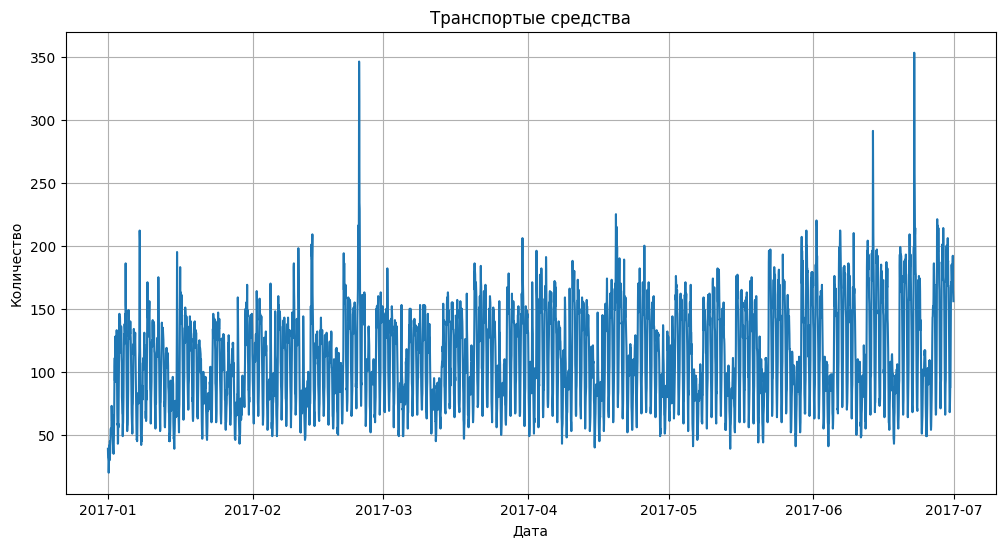

In [ ]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(12, 6))
plt.plot(dates, data)
plt.title('–¢—Ä–∞–Ω—Å–ø–æ—Ä—Ç—ã–µ —Å—Ä–µ–¥—Å—Ç–≤–∞')
plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
plt.grid(True)
plt.show()


In [8]:
print(f"–°—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: {np.mean(data)}")
print(f"–ú–µ–¥–∏–∞–Ω–∞: {np.median(data)}")
print(f"–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {np.std(data)}")
print(f"–ü–µ—Ä–≤—ã–π –∫–≤–∞—Ä—Ç–∏–ª—å (Q1): {np.percentile(data, 25)}")
print(f"–¢—Ä–µ—Ç–∏–π –∫–≤–∞—Ä—Ç–∏–ª—å (Q3): {np.percentile(data, 75)}")
print(f"–ú–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö (IQR): {np.percentile(data, 75) - np.percentile(data, 25)}")

–°—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: 111.10568731291734
–ú–µ–¥–∏–∞–Ω–∞: 106.0
–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 39.26832099463669
–ü–µ—Ä–≤—ã–π –∫–≤–∞—Ä—Ç–∏–ª—å (Q1): 79.0
–¢—Ä–µ—Ç–∏–π –∫–≤–∞—Ä—Ç–∏–ª—å (Q3): 141.0
–ú–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö (IQR): 62.0


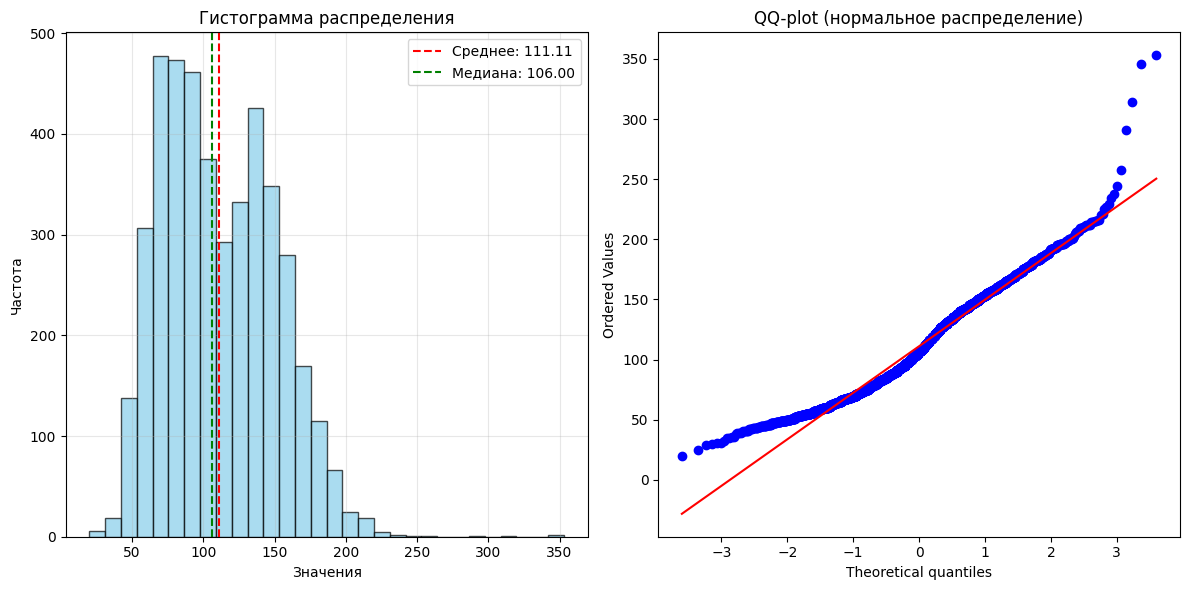

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(data), color='red', linestyle='--', label=f'–°—Ä–µ–¥–Ω–µ–µ: {np.mean(data):.2f}')
plt.axvline(np.median(data), color='green', linestyle='--', label=f'–ú–µ–¥–∏–∞–Ω–∞: {np.median(data):.2f}')
plt.xlabel('–ó–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
plt.title('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è')
plt.legend()
plt.grid(alpha=0.3)
    
# QQ-plot –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
plt.subplot(1, 2, 2)
stats.probplot(data, dist="norm", plot=plt)
plt.title('QQ-plot (–Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ)')
    
plt.tight_layout()
plt.show()

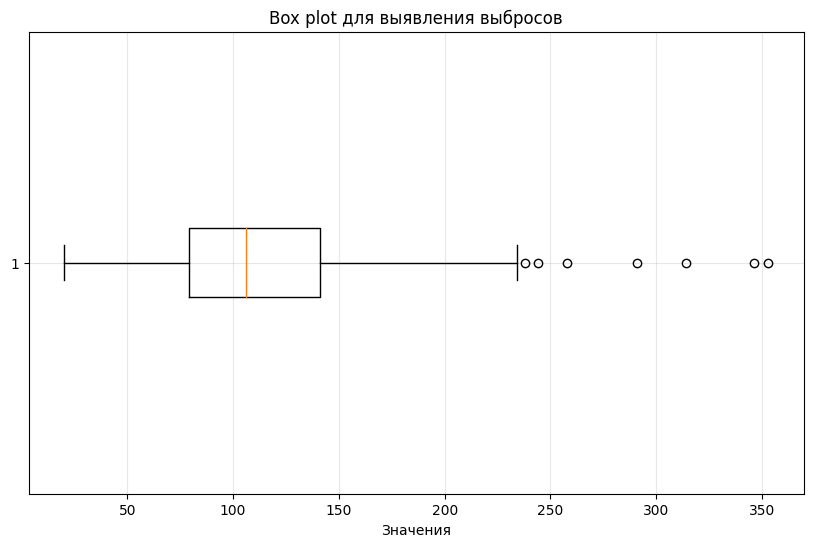

In [10]:
plt.figure(figsize=(10, 6))
plt.boxplot(data, vert=False)
plt.title('Box plot –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤')
plt.xlabel('–ó–Ω–∞—á–µ–Ω–∏—è')
plt.grid(alpha=0.3)
plt.show()

In [11]:
z_scores = np.abs(stats.zscore(data))
outliers = data[z_scores > 3]
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤: {len(outliers)}")
print(f"–ü—Ä–æ—Ü–µ–Ω—Ç –≤—ã–±—Ä–æ—Å–æ–≤: {len(outliers)/len(data)*100:.2f}%")
    
if len(outliers) > 0:
    print("–í—ã–±—Ä–æ—Å—ã:")
    for i, outlier in enumerate(outliers):
        print(f"  –í—ã–±—Ä–æ—Å {i+1}: {outlier:.4f} (z-score: {z_scores[data == outlier][0]:.2f})")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤: 9
–ü—Ä–æ—Ü–µ–Ω—Ç –≤—ã–±—Ä–æ—Å–æ–≤: 0.21%
–í—ã–±—Ä–æ—Å—ã:
  –í—ã–±—Ä–æ—Å 1: 238.0000 (z-score: 3.23)
  –í—ã–±—Ä–æ—Å 2: 346.0000 (z-score: 5.98)
  –í—ã–±—Ä–æ—Å 3: 314.0000 (z-score: 5.17)
  –í—ã–±—Ä–æ—Å 4: 234.0000 (z-score: 3.13)
  –í—ã–±—Ä–æ—Å 5: 229.0000 (z-score: 3.00)
  –í—ã–±—Ä–æ—Å 6: 291.0000 (z-score: 4.58)
  –í—ã–±—Ä–æ—Å 7: 244.0000 (z-score: 3.38)
  –í—ã–±—Ä–æ—Å 8: 353.0000 (z-score: 6.16)
  –í—ã–±—Ä–æ—Å 9: 258.0000 (z-score: 3.74)


In [12]:
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]

print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ (IQR –º–µ—Ç–æ–¥): {len(outliers_iqr)}")
for i, outlier in enumerate(outliers_iqr):
        print(f"–í—ã–±—Ä–æ—Å {i+1}: {outlier:.4f} ")
        

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ (IQR –º–µ—Ç–æ–¥): 7
–í—ã–±—Ä–æ—Å 1: 238.0000 
–í—ã–±—Ä–æ—Å 2: 346.0000 
–í—ã–±—Ä–æ—Å 3: 314.0000 
–í—ã–±—Ä–æ—Å 4: 291.0000 
–í—ã–±—Ä–æ—Å 5: 244.0000 
–í—ã–±—Ä–æ—Å 6: 353.0000 
–í—ã–±—Ä–æ—Å 7: 258.0000 


In [13]:
ts = pd.Series(data, index=dates)

In [14]:
result_mul = seasonal_decompose(ts, model='multiplicative', period=168)

<Figure size 1500x1200 with 0 Axes>

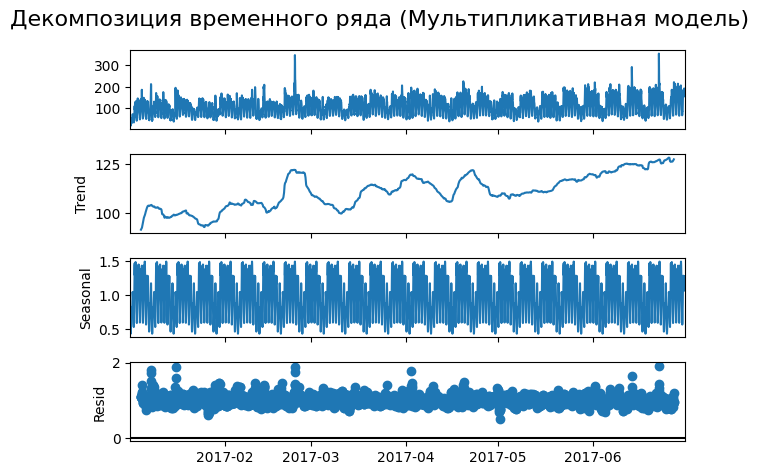

In [15]:
plt.figure(figsize=(15, 12))
result_mul.plot()
plt.suptitle('–î–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞ (–ú—É–ª—å—Ç–∏–ø–ª–∏–∫–∞—Ç–∏–≤–Ω–∞—è –º–æ–¥–µ–ª—å)', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

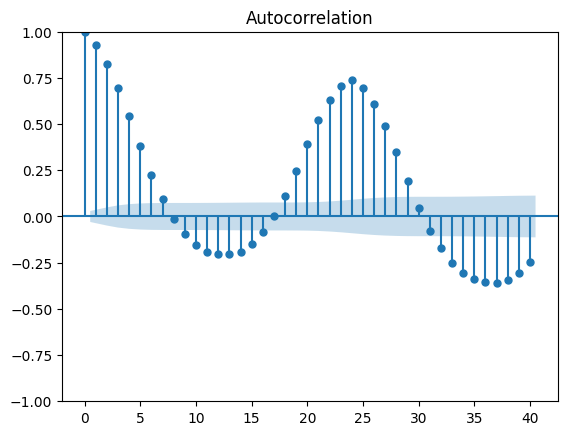

In [16]:
plt.figure(figsize=(10, 6))
plot_acf(ts, lags=40, alpha=0.05)
plt.show()

<Figure size 1000x600 with 0 Axes>

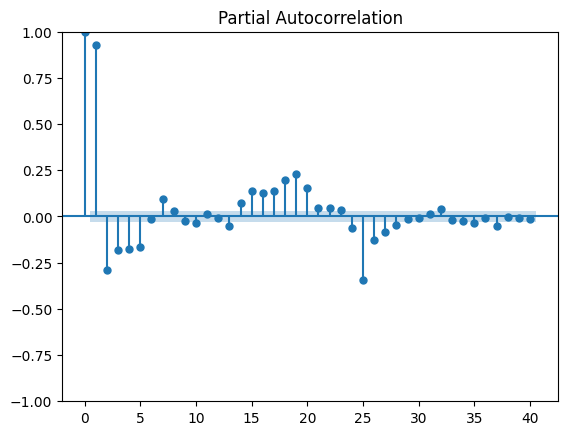

In [17]:
plt.figure(figsize=(10, 6))
plot_pacf(ts, lags=40, alpha=0.05, method='ywm')
plt.show()



In [18]:
result = adfuller(ts)
    
# –ò–∑–≤–ª–µ–∫–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
    
# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
print(f'ADF —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: {adf_statistic}')
print(f'p-value: {p_value}')
print('\n–ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è:')
for key, value in critical_values.items():
    print(f'   {key}: {value:.4f}')

ADF —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: -8.498986871187505
p-value: 1.25319517220543e-13

–ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è:
   1%: -3.4319
   5%: -2.8622
   10%: -2.5671


In [19]:
dates

DatetimeIndex(['2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               '2017-01-01 07:00:00', '2017-01-01 08:00:00',
               '2017-01-01 09:00:00', '2017-01-01 10:00:00',
               ...
               '2017-06-30 14:00:00', '2017-06-30 15:00:00',
               '2017-06-30 16:00:00', '2017-06-30 17:00:00',
               '2017-06-30 18:00:00', '2017-06-30 19:00:00',
               '2017-06-30 20:00:00', '2017-06-30 21:00:00',
               '2017-06-30 22:00:00', '2017-06-30 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=4343, freq=None)

In [20]:
def create_features(prices, dates):
    prices_series = pd.Series(prices, index=dates)
    
    features = pd.DataFrame(index=dates)

    # –õ–∞–≥–æ–≤—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏ –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏
    for lag in range(1, 7):
        features[f'lag_{lag}'] = prices_series.shift(lag)
        features[f'lag24_{lag}'] = prices_series.shift(lag*24)
        features[f'returns_{lag}'] = prices_series.pct_change(lag)
        features[f'log_{lag}'] = np.log(prices_series.shift(lag))
        features[f'diff_{lag}'] = prices_series - prices_series.shift(lag)

    # –°–∫–æ–ª—å–∑—è—â–∏–µ —Å—Ä–µ–¥–Ω–∏–µ –∏ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å (—Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ)
    for window in [3, 5, 7, 14, 21, 30]:
        features[f'ma_{window}'] = prices_series.rolling(window).mean()
        features[f'std_{window}'] = prices_series.rolling(window).std()  
        features[f'median_{window}'] = prices_series.rolling(window).median()  
        features[f'min_{window}'] = prices_series.rolling(window).min()  
        features[f'max_{window}'] = prices_series.rolling(window).max()  
        features[f'range_{window}'] = prices_series.rolling(window).max()-prices_series.rolling(window).min()
        features[f'var_{window}'] = prices_series.rolling(window).var()  

    for alpha in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]:
        features[f'ema_alpha_{alpha}'] = prices_series.ewm(alpha=alpha, adjust=False).mean()
        ema1 = prices_series.ewm(alpha=alpha, adjust=False).mean()
        ema2 = ema1.ewm(alpha=alpha, adjust=False).mean()
        features[f'dema_alpha_{alpha}'] = 2 * ema1 - ema2
        ema3 = ema2.ewm(alpha=alpha, adjust=False).mean()
        features[f'tema_alpha_{alpha}'] = 3 * ema1 - 3 * ema2 + ema3

    # RSI (Relative Strength Index)
    for period in [14, 21, 30]:
        delta = prices_series.diff()
        gain = delta.where(delta > 0, 0).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        features[f'rsi_{period}'] = 100 - (100 / (1 + rs))
    for k_period in [14, 21, 30]:
        low_min = prices_series.rolling(k_period).min()
        high_max = prices_series.rolling(k_period).max()
        features[f'stoch_k_{k_period}'] = 100 * ((prices_series - low_min) / (high_max - low_min))
        features[f'stoch_d_{k_period}'] = features[f'stoch_k_{k_period}'].rolling(3).mean()
    # Williams %R
    for period in [14, 21, 30]:
        lowest_low = prices_series.rolling(period).min()
        highest_high = prices_series.rolling(period).max()
        features[f'williams_r_{period}'] = -100 * ((highest_high - prices_series) / (highest_high - lowest_low))
    # Rate of Change (ROC)
    for period in [5, 10, 14, 21]:
        features[f'roc_{period}'] = ((prices_series - prices_series.shift(period)) / prices_series.shift(period)) * 100
    # Momentum
    for period in [5, 10, 14, 21]:
        features[f'momentum_{period}'] = prices_series - prices_series.shift(period)
        
    ema12 = prices_series.ewm(span=12, adjust=False).mean()
    ema26 = prices_series.ewm(span=26, adjust=False).mean()
    features['macd'] = ema12 - ema26
    features['macd_signal'] = features['macd'].ewm(span=9, adjust=False).mean()
    features['macd_histogram'] = features['macd'] - features['macd_signal']

    for period in [20]:
        ma = prices_series.rolling(period).mean()
        std = prices_series.rolling(period).std()
        features[f'bb_upper_{period}'] = ma + (std * 2)
        features[f'bb_middle_{period}'] = ma
        features[f'bb_lower_{period}'] = ma - (std * 2)
        features[f'bb_width_{period}'] = (features[f'bb_upper_{period}'] - features[f'bb_lower_{period}']) / ma
        features[f'bb_position_{period}'] = (prices_series - features[f'bb_lower_{period}']) / (features[f'bb_upper_{period}'] - features[f'bb_lower_{period}'])
    features['hour'] = dates.hour
    features['dayofweek'] = dates.dayofweek
    features['dayofmonth'] = dates.day
    features['month'] = dates.month
    features['quarter'] = dates.quarter
    features['dayofyear'] = dates.dayofyear
    features['weekofyear'] = dates.isocalendar().week
    features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
    features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
    
    features['dayofweek_sin'] = np.sin(2 * np.pi * features['dayofweek'] / 7)
    features['dayofweek_cos'] = np.cos(2 * np.pi * features['dayofweek'] / 7)
    
    features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
    features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)

    features['dayofyear_sin'] = np.sin(2 * np.pi * features['dayofyear'] / 365)
    features['dayofyear_cos'] = np.cos(2 * np.pi * features['dayofyear'] / 365)

    features['is_weekend'] = features['dayofweek'].isin([5, 6]).astype(int)
    features['is_month_start'] = (features['dayofmonth'] == 1).astype(int)
    features['is_month_end'] = (features.index + pd.offsets.MonthEnd(0)).day == features['dayofmonth']
    features['is_quarter_start'] = (features['dayofmonth'] == 1) & (features['month'].isin([1, 4, 7, 10])).astype(int)
    features['is_quarter_end'] = (features['dayofmonth'] == 31) & (features['month'].isin([3, 6, 9, 12])).astype(int)

    pacf_values = pacf(prices_series, nlags=30, method='ols', alpha=None)
    # –ê–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    for lag in [1, 2, 3, 7, 14, 30]:
        if len(prices_series) > lag:
            features[f'autocorr_lag_{lag}'] = prices_series.autocorr(lag=lag)
            features[f'partial_autocorr_lag_{lag}'] = pacf_values[lag]

    
    # –≠–Ω—Ç—Ä–æ–ø–∏–π–Ω—ã–µ –º–µ—Ä—ã 
    def rolling_entropy(series, window, entropy_func, **kwargs):
        results = []
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                result = entropy_func(segment.values, **kwargs)
                results.append(result)
            else:
                results.append(np.nan)
        return results
    
    for window in [100, 200, 300]:
        features[f'apen_window_{window}'] = rolling_entropy(
            prices_series, window, nolds.sampen, emb_dim=2, tolerance=0.2*np.std(prices_series))
    
    for window in [100, 200, 300]:
        # –ü—Ä–∞–≤–∏–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è sample_entropy
        features[f'sampen_window_{window}'] = rolling_entropy(
            prices_series, window, lambda x: ent.sample_entropy(x, 2, 0.2 * np.std(prices_series))[0])
    
    for window in [100, 200, 300]:
        # –ü—Ä–∞–≤–∏–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è permutation_entropy
        features[f'perm_en_window_{window}'] = rolling_entropy(
            prices_series, window, lambda x: ent.permutation_entropy(x, 3, 1))


    # –§—Ä–∞–∫—Ç–∞–ª—å–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏
    def rolling_fractal(series, window, fractal_func, **kwargs):
        results = []
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                result = fractal_func(segment.values, **kwargs)
                results.append(result)
            else:
                results.append(np.nan)
        return results

    # –ü–æ–∫–∞–∑–∞—Ç–µ–ª—å –•—ë—Ä—Å—Ç–∞
    for window in [100, 200, 300]:
        features[f'hurst_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.hurst_rs
        )
    
    # DFA (Detrended Fluctuation Analysis)
    for window in [100, 200, 300]:
        features[f'dfa_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.dfa
        )

    for window in [100, 200, 300]:
        features[f'corr_dim_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.corr_dim, emb_dim=2)
    
    for window in [100, 200, 300]:
        features[f'lyap_exp_window_{window}'] = rolling_fractal(
            prices_series, window, nolds.lyap_r, min_tsep=5, lag=1)

   # –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
    for window in [10, 20, 50]:
        features[f'cv_window_{window}'] = prices_series.rolling(window).apply(
            lambda x: variation(x))
    
    for window in [10, 20, 50]:
        features[f'concentration_index_{window}'] = prices_series.rolling(window).apply(
            lambda x: np.sum(x**2) / (np.sum(x)**2))
        
    # –°–ü–ï–ö–¢–†–ê–õ–¨–ù–´–ï –ü–†–ò–ó–ù–ê–ö–ò (–§—É—Ä—å–µ-–ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ)
    def compute_spectral_features(x):
        """–í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –≤—Ä–µ–º–µ–Ω–Ω–æ–≥–æ —Ä—è–¥–∞"""
        if len(x) < 2:
            return {
                'dft_magnitude_mean': np.nan,
                'dft_magnitude_std': np.nan,
                'psd_mean': np.nan,
                'psd_std': np.nan,
                'dominant_freq_1': np.nan,
                'dominant_freq_2': np.nan,
                'dominant_freq_3': np.nan,
                'spectral_centroid': np.nan,
                'spectral_variance': np.nan,
                'spectral_skewness': np.nan
            }
        
        # –î–∏—Å–∫—Ä–µ—Ç–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –§—É—Ä—å–µ
        dft = fft.fft(x)
        dft_magnitude = np.abs(dft)
        
        # –°–ø–µ–∫—Ç—Ä–∞–ª—å–Ω–∞—è –ø–ª–æ—Ç–Ω–æ—Å—Ç—å –º–æ—â–Ω–æ—Å—Ç–∏ (PSD)
        psd = np.abs(dft) ** 2 / len(x)
        
        # –ß–∞—Å—Ç–æ—Ç—ã
        freqs = fft.fftfreq(len(x))
        
        # –î–æ–º–∏–Ω–∏—Ä—É—é—â–∏–µ —á–∞—Å—Ç–æ—Ç—ã (—Ç–æ–ø-3 –ø–æ –∞–º–ø–ª–∏—Ç—É–¥–µ)
        dominant_indices = np.argsort(dft_magnitude)[-3:][::-1]
        dominant_freqs = freqs[dominant_indices]
        
        # –°–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã–π —Ü–µ–Ω—Ç—Ä–æ–∏–¥ (—Å—Ä–µ–¥–Ω–µ–≤–∑–≤–µ—à–µ–Ω–Ω–∞—è —á–∞—Å—Ç–æ—Ç–∞)
        if np.sum(psd) > 0:
            spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
        else:
            spectral_centroid = np.nan
        
        # –°–ø–µ–∫—Ç—Ä–∞–ª—å–Ω–∞—è –¥–∏—Å–ø–µ—Ä—Å–∏—è
        if np.sum(psd) > 0:
            spectral_variance = np.sum((freqs - spectral_centroid) ** 2 * psd) / np.sum(psd)
        else:
            spectral_variance = np.nan
        
        # –°–ø–µ–∫—Ç—Ä–∞–ª—å–Ω–∞—è –∞—Å–∏–º–º–µ—Ç—Ä–∏—è
        if np.sum(psd) > 0 and spectral_variance > 0:
            spectral_skewness = np.sum((freqs - spectral_centroid) ** 3 * psd) / (np.sum(psd) * spectral_variance ** 1.5)
        else:
            spectral_skewness = np.nan
        
        return {
            'dft_magnitude_mean': np.mean(dft_magnitude),
            'dft_magnitude_std': np.std(dft_magnitude),
            'psd_mean': np.mean(psd),
            'psd_std': np.std(psd),
            'dominant_freq_1': dominant_freqs[0],
            'dominant_freq_2': dominant_freqs[1] if len(dominant_freqs) > 1 else np.nan,
            'dominant_freq_3': dominant_freqs[2] if len(dominant_freqs) > 2 else np.nan,
            'spectral_centroid': spectral_centroid,
            'spectral_variance': spectral_variance,
            'spectral_skewness': spectral_skewness
        }

    def rolling_spectral(series, window):
        """–°–∫–æ–ª—å–∑—è—â–µ–µ –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤"""
        results = {
            'dft_magnitude_mean': [], 'dft_magnitude_std': [],
            'psd_mean': [], 'psd_std': [],
            'dominant_freq_1': [], 'dominant_freq_2': [], 'dominant_freq_3': [],
            'spectral_centroid': [], 'spectral_variance': [], 'spectral_skewness': []
        }
        
        for i in range(len(series)):
            if i >= window:
                segment = series.iloc[i-window:i]
                spectral_features = compute_spectral_features(segment.values)
                
                for key in results.keys():
                    results[key].append(spectral_features[key])
            else:
                for key in results.keys():
                    results[key].append(np.nan)
        
        return results

    # –í—ã—á–∏—Å–ª—è–µ–º —Å–ø–µ–∫—Ç—Ä–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —Ä–∞–∑–Ω—ã—Ö –æ–∫–æ–Ω
    for window in [64, 128, 256]:
        spectral_results = rolling_spectral(prices_series, window)
        
        features[f'spectral_dft_mean_window_{window}'] = spectral_results['dft_magnitude_mean']
        features[f'spectral_dft_std_window_{window}'] = spectral_results['dft_magnitude_std']
        features[f'spectral_psd_mean_window_{window}'] = spectral_results['psd_mean']
        features[f'spectral_psd_std_window_{window}'] = spectral_results['psd_std']
        
        features[f'spectral_dominant_freq_2_window_{window}'] = spectral_results['dominant_freq_2']
        features[f'spectral_dominant_freq_3_window_{window}'] = spectral_results['dominant_freq_3']
        features[f'spectral_centroid_window_{window}'] = spectral_results['spectral_centroid']
        features[f'spectral_variance_window_{window}'] = spectral_results['spectral_variance']
        features[f'spectral_skewness_window_{window}'] = spectral_results['spectral_skewness']
        
    return features.dropna()

In [21]:
features_df = pd.read_csv('/kaggle/input/parametrs/features_data.csv')
features_df = features_df.iloc[:, 1:]  
print(f"üìä –†–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {features_df.shape}")
print(f"üìã –ü—Ä–∏–∑–Ω–∞–∫–∏: {list(features_df.columns)}")


üìä –†–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: (4043, 204)
üìã –ü—Ä–∏–∑–Ω–∞–∫–∏: ['lag_1', 'lag24_1', 'returns_1', 'log_1', 'diff_1', 'lag_2', 'lag24_2', 'returns_2', 'log_2', 'diff_2', 'lag_3', 'lag24_3', 'returns_3', 'log_3', 'diff_3', 'lag_4', 'lag24_4', 'returns_4', 'log_4', 'diff_4', 'lag_5', 'lag24_5', 'returns_5', 'log_5', 'diff_5', 'lag_6', 'lag24_6', 'returns_6', 'log_6', 'diff_6', 'ma_3', 'std_3', 'median_3', 'min_3', 'max_3', 'range_3', 'var_3', 'ma_5', 'std_5', 'median_5', 'min_5', 'max_5', 'range_5', 'var_5', 'ma_7', 'std_7', 'median_7', 'min_7', 'max_7', 'range_7', 'var_7', 'ma_14', 'std_14', 'median_14', 'min_14', 'max_14', 'range_14', 'var_14', 'ma_21', 'std_21', 'median_21', 'min_21', 'max_21', 'range_21', 'var_21', 'ma_30', 'std_30', 'median_30', 'min_30', 'max_30', 'range_30', 'var_30', 'ema_alpha_0.1', 'dema_alpha_0.1', 'tema_alpha_0.1', 'ema_alpha_0.2', 'dema_alpha_0.2', 'tema_alpha_0.2', 'ema_alpha_0.3', 'dema_alpha_0.3', 'tema_alpha_0.3', 'ema_alpha_0.5', 'dema_alpha_0.5', 'te

In [23]:
data.shape

(4343,)

In [24]:
# –°–æ–∑–¥–∞—Ç—å —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (—Å–ª–µ–¥—É—é—â–∏–π –¥–µ–Ω—å)
target = pd.Series(data).shift(-1)
target.shape

(4343,)

In [25]:
# –í—ã—Ä–∞–≤–Ω–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä—ã 
valid_indices = features_df.index.intersection(target.dropna().index)
X = features_df.loc[valid_indices].values
y = target.loc[valid_indices].values

In [26]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (4043, 204)
y shape: (4043,)


In [27]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/validation/test (70/15/15)
split_idx1 = int(0.7 * len(X))
split_idx2 = int(0.85 * len(X))
X_train, X_val, X_test = X[:split_idx1], X[split_idx1:split_idx2], X[split_idx2:]
y_train, y_val, y_test = y[:split_idx1], y[split_idx1:split_idx2], y[split_idx2:]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (2830, 204), Val: (606, 204), Test: (607, 204)


In [28]:
# –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [29]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [30]:
def forward_selection(X_train, y_train, X_val, y_val, max_features=80, min_improvement=0.005): # –ü—Ä–∞–≤–∏–ª—å–Ω–µ–µ –≤–º–µ—Å—Ç–æ X_test, y_test —Å–¥–µ–ª–∞—Ç—å X_val, y_val 
    """Forward Selection –¥–ª—è –æ—Ç–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤"""
    
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    scores = []
    prev_score = -np.inf
    
    for step in range(min(max_features, n_features)):
        best_score = -np.inf
        best_feature = None
        
        # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –≤—Å–µ –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–∏–∑–Ω–∞–∫–∏
        for feature in remaining_features:
            # –°–æ–∑–¥–∞–µ–º —Ç–µ–∫—É—â–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
            current_features = selected_features + [feature]
            
            # –û–±—É—á–∞–µ–º –ª–∏–Ω–µ–π–Ω—É—é —Ä–µ–≥—Ä–µ—Å—Å–∏—é
            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)
            
            # –û—Ü–µ–Ω–∏–≤–∞–µ–º –Ω–∞ —Ç–µ—Å—Ç–µ
            score = model.score(X_val[:, current_features], y_val)
            
            if score > best_score:
                best_score = score
                best_feature = feature

        if prev_score != -np.inf:
            improvement = best_score - prev_score
        else: 
            improvement = best_score
        
        # –î–æ–±–∞–≤–ª—è–µ–º –ª—É—á—à–∏–π –ø—Ä–∏–∑–Ω–∞–∫
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        scores.append(best_score)
        
        print(f"–®–∞–≥ {step+1}: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ {best_feature}, R¬≤ = {best_score:.4f}")
        
        if improvement < min_improvement and step > 0:  # step > 0 —á—Ç–æ–±—ã –Ω–µ –æ—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞—Ç—å—Å—è –Ω–∞ –ø–µ—Ä–≤–æ–º —à–∞–≥–µ
            print(f"–û—Å—Ç–∞–Ω–æ–≤–∫–∞: —É–ª—É—á—à–µ–Ω–∏–µ –º–µ–Ω–µ–µ {min_improvement*100:.1f}%")
            break
            
        prev_score = best_score
        
    return selected_features, scores



In [31]:
def backward_selection(X_train, y_train, X_val, y_val, min_features=10, max_deterioration=0.01):
    """Backward Selection –¥–ª—è –æ—Ç–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤"""
    
    n_features = X_train.shape[1]
    selected_features = list(range(n_features))  # –Ω–∞—á–∏–Ω–∞–µ–º —Å–æ –≤—Å–µ—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    scores = []
    prev_score = -np.inf
    
    # –ë–∞–∑–æ–≤–∞—è –º–µ—Ç—Ä–∏–∫–∞ —Å–æ –≤—Å–µ–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏
    model = LinearRegression()
    model.fit(X_train[:, selected_features], y_train)
    base_score = model.score(X_val[:, selected_features], y_val)
    prev_score = base_score
    scores.append(base_score)
    
    print(f"–ù–∞—á–∞–ª—å–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ —Å–æ –≤—Å–µ–º–∏ {n_features} –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏: R¬≤ = {base_score:.4f}")
    
    step = 0
    while len(selected_features) > min_features:
        step += 1
        worst_deterioration = np.inf
        worst_feature = None
        best_score_after_removal = -np.inf
        
        # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –≤—Å–µ —Ç–µ–∫—É—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —É–¥–∞–ª–µ–Ω–∏—è
        for feature in selected_features:
            # –°–æ–∑–¥–∞–µ–º –Ω–∞–±–æ—Ä –±–µ–∑ —Ç–µ–∫—É—â–µ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞
            current_features = [f for f in selected_features if f != feature]
            
            # –û–±—É—á–∞–µ–º –ª–∏–Ω–µ–π–Ω—É—é —Ä–µ–≥—Ä–µ—Å—Å–∏—é
            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)
            
            # –û—Ü–µ–Ω–∏–≤–∞–µ–º –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
            score = model.score(X_val[:, current_features], y_val)
            
            # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º —É—Ö—É–¥—à–µ–Ω–∏–µ
            deterioration = prev_score - score
            
            # –ò—â–µ–º –ø—Ä–∏–∑–Ω–∞–∫ —Å –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–º —É—Ö—É–¥—à–µ–Ω–∏–µ–º
            if deterioration < worst_deterioration:
                worst_deterioration = deterioration
                worst_feature = feature
                best_score_after_removal = score
        
        # –£–¥–∞–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫ —Å –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–º —É—Ö—É–¥—à–µ–Ω–∏–µ–º
        selected_features.remove(worst_feature)
        scores.append(best_score_after_removal)
        
        print(f"–®–∞–≥ {step}: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ {worst_feature}, R¬≤ = {best_score_after_removal:.4f}, —É—Ö—É–¥—à–µ–Ω–∏–µ: {worst_deterioration:.4f}")
        
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º –∫—Ä–∏—Ç–µ—Ä–∏–∏ –æ—Å—Ç–∞–Ω–æ–≤–∫–∏
        if worst_deterioration > max_deterioration:
            print(f"–û—Å—Ç–∞–Ω–æ–≤–∫–∞: —É—Ö—É–¥—à–µ–Ω–∏–µ –±–æ–ª–µ–µ {max_deterioration*100:.1f}%")
            break
            
        if len(selected_features) <= min_features:
            print(f"–û—Å—Ç–∞–Ω–æ–≤–∫–∞: –¥–æ—Å—Ç–∏–≥–Ω—É—Ç–æ –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ({min_features})")
            break
            
        prev_score = best_score_after_removal
        
    return selected_features, scores

In [32]:

# –ó–∞–ø—É—Å–∫ –æ—Ç–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
forward_selected_features, forward_selection_scores = forward_selection(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
)



–®–∞–≥ 1: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 103, R¬≤ = 0.3794
–®–∞–≥ 2: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 128, R¬≤ = 0.5654
–®–∞–≥ 3: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 127, R¬≤ = 0.6302
–®–∞–≥ 4: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 125, R¬≤ = 0.6705
–®–∞–≥ 5: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 61, R¬≤ = 0.7057
–®–∞–≥ 6: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 91, R¬≤ = 0.7354
–®–∞–≥ 7: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 111, R¬≤ = 0.7562
–®–∞–≥ 8: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 155, R¬≤ = 0.7778
–®–∞–≥ 9: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 67, R¬≤ = 0.7884
–®–∞–≥ 10: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 54, R¬≤ = 0.8017
–®–∞–≥ 11: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 177, R¬≤ = 0.8093
–®–∞–≥ 12: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 170, R¬≤ = 0.8156
–®–∞–≥ 13: –¥–æ–±–∞–≤–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 126, R¬≤ = 0.8204
–û—Å—Ç–∞–Ω–æ–≤–∫–∞: —É–ª—É—á—à–µ–Ω–∏–µ –º–µ–Ω–µ–µ 0.5%


In [33]:
forward_selected_features

[103, 128, 127, 125, 61, 91, 111, 155, 67, 54, 177, 170, 126]

In [34]:
# –ó–∞–ø—É—Å–∫ –æ—Ç–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
backward_selected_features, backward_selection_scores = backward_selection(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
)

–ù–∞—á–∞–ª—å–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ —Å–æ –≤—Å–µ–º–∏ 204 –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏: R¬≤ = -13041906587289952.0000
–®–∞–≥ 1: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 120, R¬≤ = 0.5616, —É—Ö—É–¥—à–µ–Ω–∏–µ: -13041906587289952.0000
–®–∞–≥ 2: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 155, R¬≤ = 0.7628, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.2012
–®–∞–≥ 3: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 166, R¬≤ = 0.8136, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0508
–®–∞–≥ 4: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 156, R¬≤ = 0.8377, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0242
–®–∞–≥ 5: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 135, R¬≤ = 0.8493, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0115
–®–∞–≥ 6: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 189, R¬≤ = 0.8582, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0089
–®–∞–≥ 7: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 198, R¬≤ = 0.8689, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0107
–®–∞–≥ 8: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 76, R¬≤ = 0.8752, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0063
–®–∞–≥ 9: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 78, R¬≤ = 0.8782, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0030
–®–∞–≥ 10: —É–¥–∞–ª–µ–Ω –ø—Ä–∏–∑–Ω–∞–∫ 125, R¬≤ = 0.8862, —É—Ö—É–¥—à–µ–Ω–∏–µ: -0.0080
–®–∞–≥ 11: —É–¥–∞–ª–µ–Ω –ø—Ä–

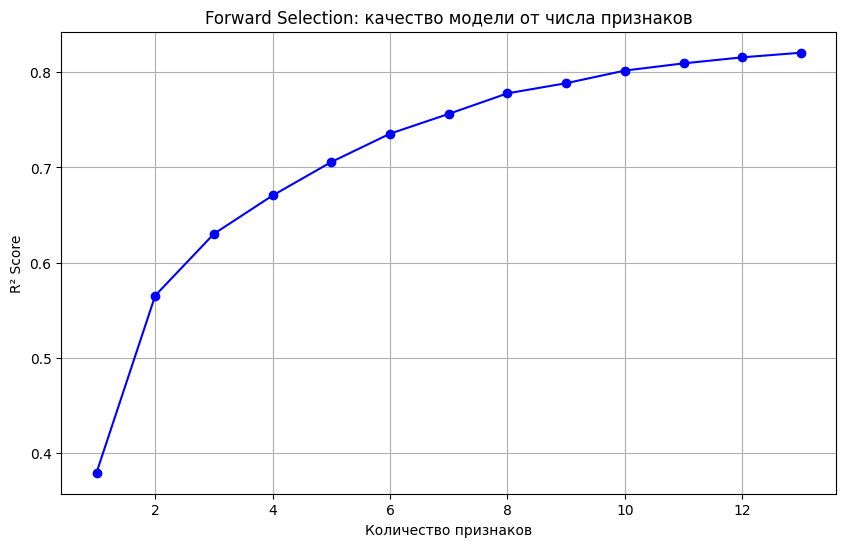

In [35]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(forward_selection_scores)+1), forward_selection_scores, 'bo-')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.ylabel('R¬≤ Score')
plt.title('Forward Selection: –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –æ—Ç —á–∏—Å–ª–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.grid(True)
plt.show()



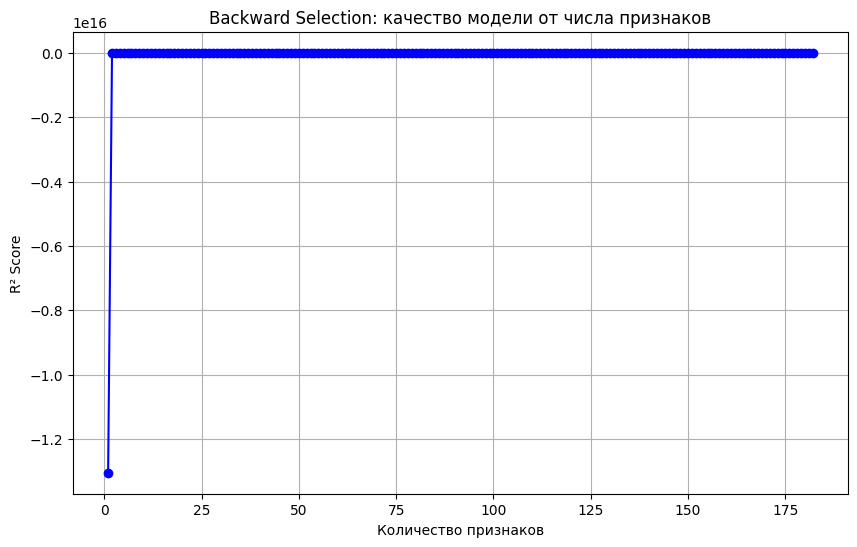

In [36]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(backward_selection_scores)+1), backward_selection_scores, 'bo-')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.ylabel('R¬≤ Score')
plt.title('Backward Selection: –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏ –æ—Ç —á–∏—Å–ª–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
plt.grid(True)
plt.show()

In [37]:
# –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
forward_optimal_n_features = np.argmax(forward_selection_scores) + 1
print(f"–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ forward_selection: {forward_optimal_n_features}")

–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ forward_selection: 13


In [38]:
# –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
backward_optimal_n_features = np.argmax(backward_selection_scores) + 1
print(f"–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ backward_selection: {backward_optimal_n_features}")

–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ backward_selection: 124


In [39]:
# –ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏–º, —á—Ç–æ features_df - —ç—Ç–æ DataFrame —Å –Ω–∞–∑–≤–∞–Ω–∏—è–º–∏ –∫–æ–ª–æ–Ω–æ–∫
feature_names = features_df.columns.tolist()

# –ü–æ–ª—É—á–∞–µ–º –Ω–∞–∑–≤–∞–Ω–∏—è –¥–ª—è forward selection
forward_feature_names = [feature_names[i] for i in forward_selected_features]

# –ü–æ–ª—É—á–∞–µ–º –Ω–∞–∑–≤–∞–Ω–∏—è –¥–ª—è backward selection  
backward_feature_names = [feature_names[i] for i in backward_selected_features]

print("Forward selected features:")
for i, (idx, name) in enumerate(zip(forward_selected_features, forward_feature_names)):
    print(f"{i+1}. {name} (index: {idx})")

print("\nBackward selected features:")
for i, (idx, name) in enumerate(zip(backward_selected_features, backward_feature_names)):
    print(f"{i+1}. {name} (index: {idx})")

Forward selected features:
1. roc_10 (index: 103)
2. dayofweek_cos (index: 128)
3. dayofweek_sin (index: 127)
4. hour_sin (index: 125)
5. min_21 (index: 61)
6. rsi_21 (index: 91)
7. macd_signal (index: 111)
8. sampen_window_300 (index: 155)
9. median_30 (index: 67)
10. min_14 (index: 54)
11. spectral_dft_mean_window_64 (index: 177)
12. lyap_exp_window_300 (index: 170)
13. hour_cos (index: 126)

Backward selected features:
1. lag_1 (index: 0)
2. diff_1 (index: 4)
3. lag_2 (index: 5)
4. ema_alpha_0.1 (index: 72)
5. dema_alpha_0.1 (index: 73)
6. tema_alpha_0.1 (index: 74)
7. ema_alpha_0.2 (index: 75)
8. tema_alpha_0.2 (index: 77)
9. dema_alpha_0.3 (index: 79)
10. ema_alpha_0.5 (index: 81)
11. dema_alpha_0.5 (index: 82)
12. tema_alpha_0.5 (index: 83)
13. ema_alpha_0.7 (index: 84)
14. tema_alpha_0.7 (index: 86)
15. ema_alpha_0.9 (index: 87)
16. tema_alpha_0.9 (index: 89)
17. roc_10 (index: 103)
18. macd_signal (index: 111)
19. macd_histogram (index: 112)
20. dayofyear (index: 123)
21. dayof

In [40]:


def display_comparison_summary(forward_features, forward_scores,
                             backward_features, backward_scores,
                             feature_names=None):
    """
    –û—Ç–æ–±—Ä–∞–∂–∞–µ—Ç —Å–≤–æ–¥–Ω—É—é —Ç–∞–±–ª–∏—Ü—É —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –º–µ—Ç–æ–¥–æ–≤
    """
    
    # –û—Å–Ω–æ–≤–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞
    summary_data = {
        'Metric': [
            'Total Features Selected',
            'Final R¬≤ Score',
            'Best R¬≤ Score',
            'First Feature Selected',
            'Last Feature Selected'
        ],
        'Forward Selection': [
            len(forward_features),
            forward_scores[-1] if forward_scores else None,
            max(forward_scores) if forward_scores else None,
            feature_names[forward_features[0]] if feature_names and forward_features else f'Feature {forward_features[0]}',
            feature_names[forward_features[-1]] if feature_names and forward_features else f'Feature {forward_features[-1]}'
        ],
        'Backward Selection': [
            len(backward_features),
            backward_scores[-1] if backward_scores else None,
            max(backward_scores) if backward_scores else None,
            feature_names[backward_features[-1]] if feature_names and backward_features else f'Feature {backward_features[-1]}',
            feature_names[backward_features[0]] if feature_names and backward_features else f'Feature {backward_features[0]}'
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    
    # –û–±—â–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    common_features = set(forward_features) & set(backward_features)
    common_features_list = []
    
    if common_features:
        if feature_names:
            common_features_list = [feature_names[idx] for idx in common_features]
        else:
            common_features_list = [f'Feature {idx}' for idx in common_features]
    
   
    print("–°–†–ê–í–ù–ò–¢–ï–õ–¨–ù–ê–Ø –¢–ê–ë–õ–ò–¶–ê: FORWARD vs BACKWARD SELECTION")
    
    
    display(df_summary.style.set_properties(**{'text-align': 'left'}))
    
    print(f"\n–û–±—â–∏–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ ({len(common_features)}):")
    for feature in common_features_list:
        print(f"  ‚Ä¢ {feature}")
    
    return df_summary, common_features_list





In [41]:

# –°–≤–æ–¥–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞
df_summary, common_features = display_comparison_summary(
    forward_selected_features, forward_selection_scores,
    backward_selected_features, backward_selection_scores,
    feature_names
)





–°–†–ê–í–ù–ò–¢–ï–õ–¨–ù–ê–Ø –¢–ê–ë–õ–ò–¶–ê: FORWARD vs BACKWARD SELECTION



–û–±—â–∏–µ –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (2):
  ‚Ä¢ macd_signal
  ‚Ä¢ roc_10


In [65]:
ridge_model = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=tscv,  # –ò—Å–ø–æ–ª—å–∑—É–µ–º TimeSeriesSplit –¥–ª—è –≤—Ä–µ–º–µ–Ω–Ω—ã—Ö —Ä—è–¥–æ–≤
    scoring='neg_mean_squared_error',  # –ú–∏–Ω–∏–º–∏–∑–∏—Ä—É–µ–º MSE
    n_jobs=-1,  # –ò—Å–ø–æ–ª—å–∑—É–µ–º –≤—Å–µ —è–¥—Ä–∞ –ø—Ä–æ—Ü–µ—Å—Å–æ—Ä–∞
    verbose=1
)
print("–ó–∞–ø—É—Å–∫ GridSearchCV...")
grid_search.fit(X_train_scaled[:, backward_selected_features], y_train_scaled)
# 5. –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã GridSearchCV:")
print(f"–õ—É—á—à–∏–π –ø–∞—Ä–∞–º–µ—Ç—Ä alpha: {grid_search.best_params_['alpha']}")
print(f"–õ—É—á—à–∏–π MSE: {-grid_search.best_score_:.4f}")

best_ridge = grid_search.best_estimator_

y_test_pred_ridge = best_ridge.predict(X_test_scaled[:, backward_selected_features])
test_mse_ridge = mean_squared_error(y_test_scaled, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test_scaled, y_test_pred_ridge)

print(f"\nTest —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã:")
print(f"MSE: {test_mse_ridge:.4f}")
print(f"R¬≤: {test_r2_ridge:.4f}")

–ó–∞–ø—É—Å–∫ GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

–†–µ–∑—É–ª—å—Ç–∞—Ç—ã GridSearchCV:
–õ—É—á—à–∏–π –ø–∞—Ä–∞–º–µ—Ç—Ä alpha: 100
–õ—É—á—à–∏–π MSE: 0.5204

Test —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã:
MSE: 0.7020
R¬≤: 0.5594


forward_selected_features –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å–∞—Ç –Ω–∞ test

In [68]:
xgb_model = xgb.XGBRegressor(
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)  
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=1,
    return_train_score=True
)
print("–ó–∞–ø—É—Å–∫ GridSearchCV –¥–ª—è XGBoost...")
grid_search.fit(
    X_train_scaled[:, backward_selected_features], y_train_scaled,
    eval_set=[(X_val_scaled[:, backward_selected_features], y_val_scaled)],  # Early stopping –Ω–∞ validation set
    verbose=False
)
print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã GridSearchCV:")
print(f"–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: {grid_search.best_params_}")
print(f"–õ—É—á—à–∏–π MSE: {-grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

y_test_pred_xgb = best_xgb.predict(X_test_scaled[:, backward_selected_features])
test_mse_xgb = mean_squared_error(y_test_scaled, y_test_pred_xgb)
test_r2_xgb = r2_score(y_test_scaled, y_test_pred_xgb)

print(f"\nTest —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã:")
print(f"MSE: {test_mse_xgb:.4f}")
print(f"R¬≤: {test_r2_xgb:.4f}")

–ó–∞–ø—É—Å–∫ GridSearchCV –¥–ª—è XGBoost...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

–†–µ–∑—É–ª—å—Ç–∞—Ç—ã GridSearchCV:
–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
–õ—É—á—à–∏–π MSE: 0.4217

Test —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã:
MSE: 0.7129
R¬≤: 0.5525


In [87]:
def create_sequences(data, seq_length):
    """
    –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π –¥–ª—è RNN
    
    –ó–∞—á–µ–º —ç—Ç–æ –Ω—É–∂–Ω–æ:
    RNN —Ä–∞–±–æ—Ç–∞—é—Ç —Å –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—è–º–∏ —Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –¥–ª–∏–Ω—ã, –Ω–æ –Ω–∞—à–∏ –¥–∞–Ω–Ω—ã–µ - 
    —ç—Ç–æ –æ–¥–∏–Ω –¥–ª–∏–Ω–Ω—ã–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Ä—è–¥. –ú—ã —Å–æ–∑–¥–∞–µ–º "—Å–∫–æ–ª—å–∑—è—â–µ–µ –æ–∫–Ω–æ":
    
    –ü—Ä–∏–º–µ—Ä: data = [100, 102, 101, 105, 107, 103], seq_length = 3
    –†–µ–∑—É–ª—å—Ç–∞—Ç:
    X[0] = [100, 102, 101] ‚Üí y[0] = 105
    X[1] = [102, 101, 105] ‚Üí y[1] = 107  
    X[2] = [101, 105, 107] ‚Üí y[2] = 103
    
    –≠—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç RNN —É—á–∏—Ç—å—Å—è –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—Ç—å —Å–ª–µ–¥—É—é—â—É—é —Ç–æ—á–∫—É –Ω–∞ –æ—Å–Ω–æ–≤–µ –∏—Å—Ç–æ—Ä–∏–∏.
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        # –ë–µ—Ä–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ seq_length —Ç–æ—á–µ–∫ –∫–∞–∫ –≤—Ö–æ–¥–Ω—É—é –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å
        X.append(data[i-seq_length:i])
        # –°–ª–µ–¥—É—é—â–∞—è —Ç–æ—á–∫–∞ - —ç—Ç–æ —Ü–µ–ª—å –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
        y.append(data[i] if len(data[i].shape) == 0 else data[i, 0])
    return np.array(X), np.array(y)




In [94]:
def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs, patience, lr, batch_size):
    """–û–±—É—á–µ–Ω–∏–µ PyTorch –º–æ–¥–µ–ª–∏ —Å GPU –ø–æ–¥–¥–µ—Ä–∂–∫–æ–π"""
    # –ü–µ—Ä–µ–Ω–æ—Å–∏–º –º–æ–¥–µ–ª—å –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # –ö–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –≤ —Ç–µ–Ω–∑–æ—Ä—ã –∏ –ø–µ—Ä–µ–Ω–æ—Å–∏–º –Ω–∞ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    for epoch in range(epochs):
        # –û–±—É—á–µ–Ω–∏–µ
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            train_pred = model(X_batch)
            train_loss = criterion(train_pred.squeeze(), y_batch)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        # –°—Ä–µ–¥–Ω–∏–π loss –∑–∞ —ç–ø–æ—Ö—É
        avg_train_loss = epoch_train_loss / len(train_loader)
        
        # –í–∞–ª–∏–¥–∞—Ü–∏—è
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred.squeeze(), y_val_tensor)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, 'f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    

    
    # –û—á–∏—Å—Ç–∫–∞ GPU –∫—ç—à–∞
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # –ó–∞–≥—Ä—É–∂–∞–µ–º –ª—É—á—à–∏–µ –≤–µ—Å–∞
    model.load_state_dict(best_model_weights)
    return  model, train_losses, val_losses




In [95]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, num_layers=2, dropout=0.2, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        output = self.fc(x[:, -1, :])  # –ü–æ—Å–ª–µ–¥–Ω–∏–π –≤—ã—Ö–æ–¥
        return output



In [96]:
param_grid = {
    'sequence_length': [10, 20, 30, 50],
    'dropout': [0.2, 0.3],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [98]:
best_score = float('inf')
best_params = {}
    
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
        
    # –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π
    X_seq_train, y_seq_train = create_sequences(X_train_scaled[:, forward_selected_features], params['sequence_length'])
    X_seq_val, y_seq_val = create_sequences(X_val_scaled[:, forward_selected_features], params['sequence_length'])
        
    # –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∏ –æ–±—É—á–µ–Ω–∏–µ
    model = SimpleLSTM(
        input_size=X_seq_train.shape[2],
        dropout=params['dropout']
    )

    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    trained_model, train_losses, val_losses = train_pytorch_model(
        model=model,
        X_train=X_seq_train,
        y_train=y_seq_train,
        X_val=X_seq_val,
        y_val=y_seq_val,
        epochs=100,
        patience=10,
        lr=params['learning_rate'],
        batch_size=params['batch_size']
    )

    # –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏
    trained_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_seq_val).to(device)
        val_pred = trained_model(X_val_tensor)
        val_score = nn.MSELoss()(val_pred.squeeze(), torch.FloatTensor(y_seq_val).to(device)).item()
        
    if val_score < best_score:
        best_score = val_score
        best_params = params.copy()
        best_model = trained_model
        print(f"New best score! Params: {best_params}, Score: {best_score:.4f}")
    
 

Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 10}
Epoch   0: Train Loss: 0.0227, Val Loss: 0.1318, LR: 0.001000
Epoch  10: Train Loss: 0.0446, Val Loss: 0.0900, LR: 0.001000
Epoch  20: Train Loss: 0.0412, Val Loss: 0.0916, LR: 0.001000
Early stopping at epoch 27
New best score! Params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 10}, Score: 0.1075
Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 20}
Epoch   0: Train Loss: 0.0472, Val Loss: 0.1156, LR: 0.001000
Epoch  10: Train Loss: 0.0270, Val Loss: 0.1128, LR: 0.001000
Epoch  20: Train Loss: 0.0249, Val Loss: 0.0998, LR: 0.001000
Early stopping at epoch 27
New best score! Params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 20}, Score: 0.0789
Testing params: {'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'sequence_length': 30}
Epoch   0: Train Loss: 0.2352, Val Los

In [100]:
X_rnn_test, y_rnn_test = create_sequences(X_test_scaled[:, forward_selected_features], seq_length)

# –û—Ü–µ–Ω–∫–∞ LSTM
lstm_model.eval()
with torch.no_grad():
    lstm_pred = best_model(torch.FloatTensor(X_rnn_test).to(device))
    lstm_r2 = r2_score(y_rnn_test, lstm_pred.squeeze().cpu().numpy())
    lstm_mse = mean_squared_error(y_rnn_test, lstm_pred.squeeze().cpu().numpy())
print(f"LSTM R¬≤: {lstm_r2:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")

LSTM R¬≤: 0.9218
LSTM MSE: 0.1392
